In [1]:
#from tensorflow import keras
import keras
keras.__version__

2024-09-17 19:34:34.954937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-17 19:34:35.199907: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-17 19:34:35.264470: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-17 19:34:35.650125: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-17 19:34:45.811221: W tensorflow/compiler/tf2

'3.5.0'

In [3]:
import tensorflow as tf
print(tf.__version__)  # 2.15.0이 출력되어야 합니다.

2.17.0


# 5.1 - 합성곱 신경망 소개

이 노트북은 [케라스 창시자에게 배우는 딥러닝](https://tensorflow.blog/%EC%BC%80%EB%9D%BC%EC%8A%A4-%EB%94%A5%EB%9F%AC%EB%8B%9D/) 책의 5장 1절의 코드 예제입니다.

    - 책에는 더 많은 내용과 그림이 있습니다. 이 노트북에는 소스 코드에 관련된 설명만 포함합니다.

----

- 컨브넷의 정의와 컨브넷이 컴퓨터 비전 관련 작업에 잘 맞는 이유에 대해 이론적 배경을 알아보겠습니다.
- 하지만 먼저 간단한 컨브넷 예제를 둘러 보죠. 2장에서 완전 연결 네트워크로 풀었던(이 방식의 테스트 정확도는 97.8%였습니다) MNIST 숫자 이미지 분류에 컨브넷을 사용해 보겠습니다.
- 기본적인 컨브넷이더라도 2장의 완전 연결된 모델의 성능을 훨씬 앞지를 것입니다.

- 다음 코드는 기본적인 컨브넷의 모습입니다. `Conv2D`와 `MaxPooling2D` 층을 쌓아 올렸습니다.

- 잠시 후에 이들이 무엇인지 배우겠습니다.

- 컨브넷이 `(image_height, image_width, image_channels)` 크기의 입력 텐서를 사용한다는 점이 중요합니다(배치 차원은 포함하지 않습니다).

- 이 예제에서는 MNIST 이미지 포맷인 `(28, 28, 1)` 크기의 입력을 처리하도록 컨브넷을 설정해야 합니다.

- 이 때문에 첫 번째 층의 매개변수로 `input_shape=(28, 28, 1)`을 전달합니다.

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


지금까지 컨브넷 구조를 출력해 보죠:

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 64)            │          36,928 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,744 (217.75 KB)

 Trainable params: 55,744 (217.75 KB)

 Non-trainable params: 0 (0.00 B)



```
conv2d (Conv2D)             (None, 26, 26, 32)        320      ==> ( 1 x 3 x 3 + 1) x 32

conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496    ==> (32 x 3 x 3 + 1) x 64

conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928    ==> (64 x 3 x 3 + 1) x 64
```



- `Conv2D`와 `MaxPooling2D` 층의 출력은 `(height, width, channels)` 크기의 3D 텐서입니다.
- 높이와 넓이 차원은 네트워크가 깊어질수록 작아지는 경향이 있습니다.
- 채널의 수는 `Conv2D` 층에 전달된 첫 번째 매개변수에 의해 조절됩니다(32개 또는 64.개).


---



- 다음 단계에서 마지막 층의 (`(3, 3, 64)` 크기인) 출력 텐서를 완전 연결 네트워크에 주입합니다.
- 이 네트워크는 이미 익숙하게 보았던 `Dense` 층을 쌓은 분류기입니다.
- 이 분류기는 1D 벡터를 처리하는데 이전 층의 출력이 3D 텐서입니다.
- 그래서 먼저 3D 출력을 1D 텐서로 펼쳐야 합니다.
- 그다음 몇 개의 `Dense` 층을 추가합니다:

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

10개의 클래스를 분류하기 위해 마지막 층의 출력 크기를 10으로 하고 소프트맥스 활성화 함수를 사용합니다. 이제 전체 네트워크는 다음과 같습니다:

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)



```
dense (Dense)               (None, 64)                36928    ===>   576 x 64 + 64

dense_1 (Dense)             (None, 10)                650      ===>    64 x 10 + 10
```



- 여기에서 볼 수 있듯이 `(3, 3, 64)` 출력이 `(576,)` 크기의 벡터로 펼쳐진 후 `Dense` 층으로 주입되었습니다.

- 이제 MNIST 숫자 이미지에 이 컨브넷을 훈련합니다.

- 2장의 MNIST 예제 코드를 많이 재사용하겠습니다.

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)     # to_categorical - one hot encoding을 해 주는 함수
test_labels = to_categorical(test_labels)       # to_categorical - one hot encoding을 해 주는 함수

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8760 - loss: 0.3949
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9840 - loss: 0.0519
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9898 - loss: 0.0328
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9930 - loss: 0.0228
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9944 - loss: 0.0173


- 테스트 데이터에서 모델을 평가해 보죠:

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9856 - loss: 0.0442


In [ ]:
test_acc

0.9894999861717224

- 2장의 완전 연결 네트워크는 97.8%의 테스트 정확도를 얻은 반면, 기본적인 컨브넷은 99.2%의 테스트 정확도를 얻었습니다.
- 에러율이 (상대적으로) 64%나 줄었습니다.
- 나쁘지 않군요!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- [2_1](https://drive.google.com/file/d/1JjwocjvUGVb_ioAY_297NSESi9WP-bN9/view?usp=sharing)
- [3_1](https://drive.google.com/file/d/1zeY_iKdIeR30nRohu1U-NTFNPH4q9oRt/view?usp=sharing)
- [7_1](https://drive.google.com/file/d/13g_Nbkj-Mrhvg8SCopQ_oT2GRxQQ5hs9/view?usp=sharing)
- [7_2](https://drive.google.com/file/d/1Gpyc0BxFFpnpMJiJomtEd2i42LHCgVsY/view?usp=sharing)
- [8_1](https://drive.google.com/file/d/1PfEaTz5TWVeXw0Ri0DNgP1F1TzmXnsMk/view?usp=sharing)
- [9_1](https://drive.google.com/file/d/1QGEw6pgJ6JWNBO-LlNMc8mIzlSdaKvET/view?usp=sharing)


In [ ]:
!cp -r /content/drive/MyDrive/data/2_1.png /content/
!cp -r /content/drive/MyDrive/data/3_1.png /content/
!cp -r /content/drive/MyDrive/data/7_1.png /content/
!cp -r /content/drive/MyDrive/data/7_2.png /content/
!cp -r /content/drive/MyDrive/data/8_1.png /content/
!cp -r /content/drive/MyDrive/data/9_1.png /content/

In [ ]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

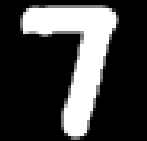

In [ ]:
#img = cv2.imread('9_1.png')
#img = cv2.imread('8_1.png')
img = cv2.imread('7_2.png')
#img = cv2.imread('7_1.png')
#img = cv2.imread('2_1.png')
#img = cv2.imread('3_1.png')
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
import numpy as np

In [ ]:
img = cv2.resize(img, (28,28))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#img = np.reshape(img, (784, ))

test_image = img.reshape(1,28,28,1)

#X = np.asarray([img])
#predictions = model(X, training=False)
predictions = model.predict(test_image)
print(predictions)
print(np.argmax(predictions))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
7
